# Прогнозирование уровня средней заработной платы в России

In [254]:
%matplotlib
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Using matplotlib backend: Qt5Agg


In [255]:
salary_data = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'],dayfirst=True)
salary_data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


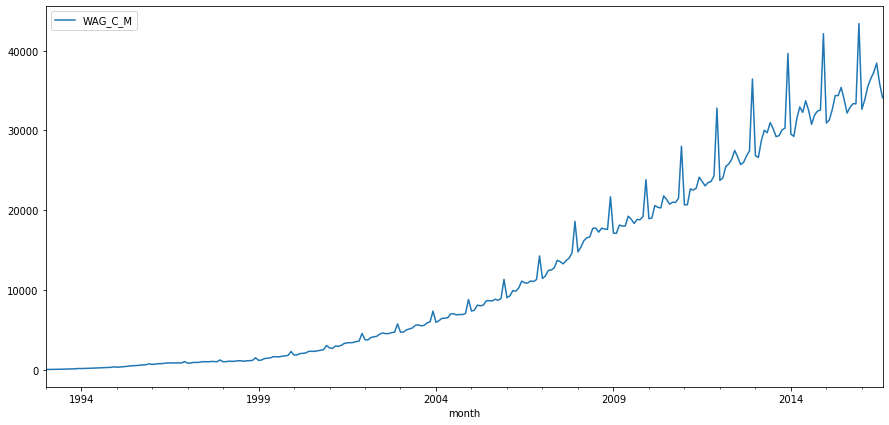

In [256]:
salary_data.plot()

### Визуальный анализ ряда

Ряд обладает якро выраженным повышаюшим трендом. Также по графику можно отметить годовую сезонность. Кроме того дисперсия ряда кажется не стационарной.

### Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

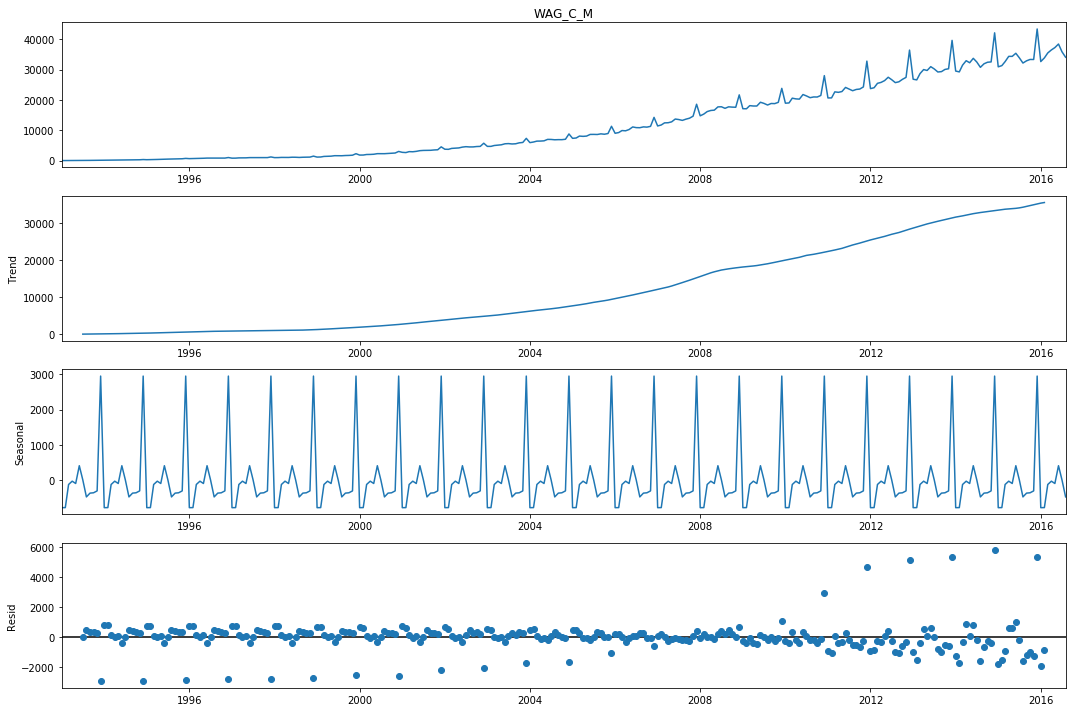

In [257]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary_data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary_data.WAG_C_M)[1])

Т.к. 0.991850 > 0.05, то нулевая гипотеза о нестационарности этого ряда не отвергается согласно критерию Дики-Фуллера.
Анализ STL-декомпозиции позволяет сделать следующие выводы - сезанный профиль ярко выражен; наблюдается повышаюший почти линейный тренд, в очередной раз подтвержает гипотезу в нестационарности ряда.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


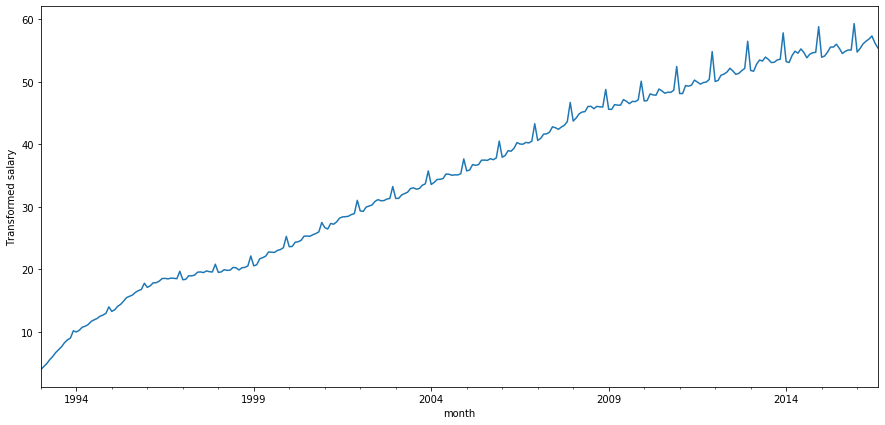

In [258]:
salary_data['WAG_C_M_box'], lmbda = stats.boxcox(salary_data.WAG_C_M)
plt.figure(figsize(15,7))
salary_data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary_data.WAG_C_M_box)[1])

### Выбор порядка дифференцирования

Попробуем обычное дифференцирование, сезонное и их комбинацию. Построим графики и проверим гипотезу проверим нестационарности.

Критерий Дики-Фуллера обычное дифференцирование: p=0.014396
Критерий Дики-Фуллера сезонное дифференцирование: p=0.014697
Критерий Дики-Фуллера комбинации дифференцирований: p=0.000000


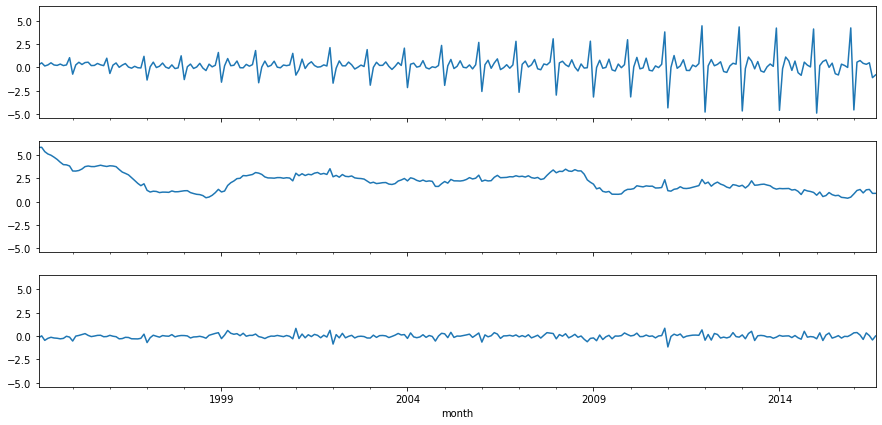

In [259]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)

# обычное дифференцирование 
salary_data['WAG_C_M_diff1'] = salary_data.WAG_C_M_box - salary_data.WAG_C_M_box.shift(1)
salary_data.WAG_C_M_diff1.dropna(inplace=True)
salary_data.WAG_C_M_diff1.plot(ax=ax1)
print("Критерий Дики-Фуллера обычное дифференцирование: p=%f" % sm.tsa.stattools.adfuller(salary_data.WAG_C_M_diff1)[1])

# сезонное дифференцирование 
salary_data['WAG_C_M_diff2'] = salary_data.WAG_C_M_box - salary_data.WAG_C_M_box.shift(12)
salary_data.WAG_C_M_diff2.dropna(inplace=True)
salary_data.WAG_C_M_diff2.plot(ax=ax2)
print("Критерий Дики-Фуллера сезонное дифференцирование: p=%f" % sm.tsa.stattools.adfuller(salary_data.WAG_C_M_diff2)[1])

# сезонное и обычное дифференцирование 
salary_data['WAG_C_M_diff3'] = salary_data.WAG_C_M_diff2 - salary_data.WAG_C_M_diff2.shift(1)
salary_data.WAG_C_M_diff3.dropna(inplace=True)
salary_data.WAG_C_M_diff3.plot(ax=ax3)
print("Критерий Дики-Фуллера комбинации дифференцирований: p=%f" % sm.tsa.stattools.adfuller(salary_data.WAG_C_M_diff3)[1])

Не смотря на то, что критерий Дики-Фуллера отвергает гипотезу о нетсационарности для всех полученных рядов, выберем поседний вариант с сезонным и обычным дифференцированием, т.к. график полученного ряда больше всего похож на стационарный и гипотеза отвергается более уверенно. 

### Выбор начальных приближений для p, q, P, Q

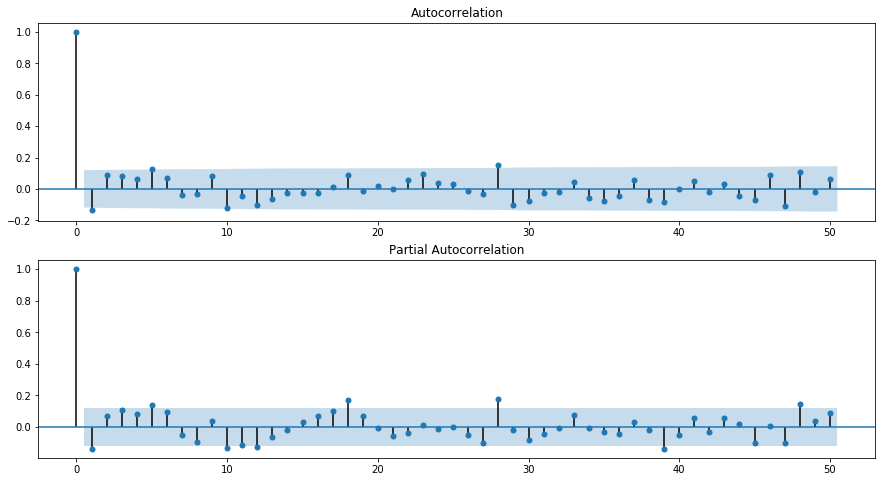

In [260]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary_data.WAG_C_M_diff3.values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary_data.WAG_C_M_diff3.values.squeeze(), lags=50, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=5, P=4, p=5

### Обучение и сравнение моделей-кандидатов, выбор победителя

In [130]:
ps = range(0, 6)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [131]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print("Количество моделей: ", len(parameters_list))

Количество моделей:  72


In [185]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary_data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 2min 7s


In [186]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
32  (2, 2, 0, 0) -21.488595
34  (2, 2, 1, 0) -21.473461
33  (2, 2, 0, 1) -21.240103
35  (2, 2, 1, 1) -21.053114
46  (3, 2, 1, 0) -20.360800


In [187]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  15.744
Date:                             Fri, 19 Jun 2020   AIC                            -21.489
Time:                                     22:43:41   BIC                             -3.478
Sample:                                 01-01-1993   HQIC                           -14.257
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.952      0.000       1.400       1.571
ar.L2         -0.6838      

### Анализ остатков 

Критерий Стьюдента: p=0.269836
Критерий Дики-Фуллера: p=0.000000


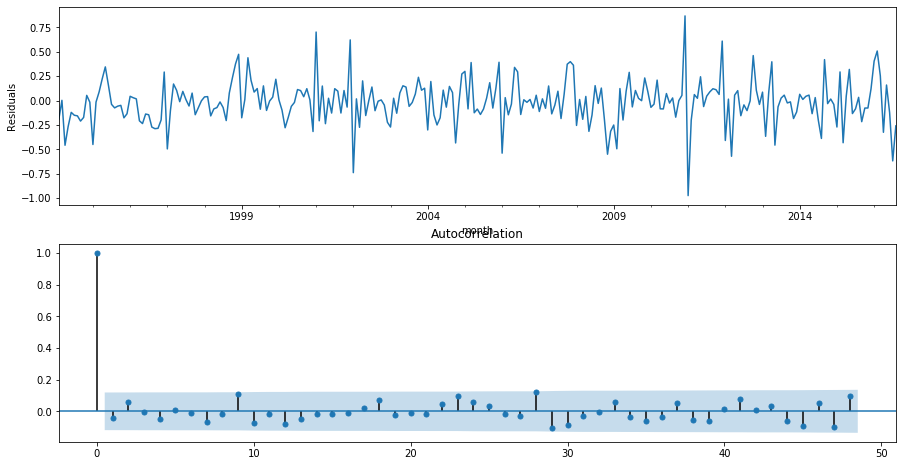

In [195]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные

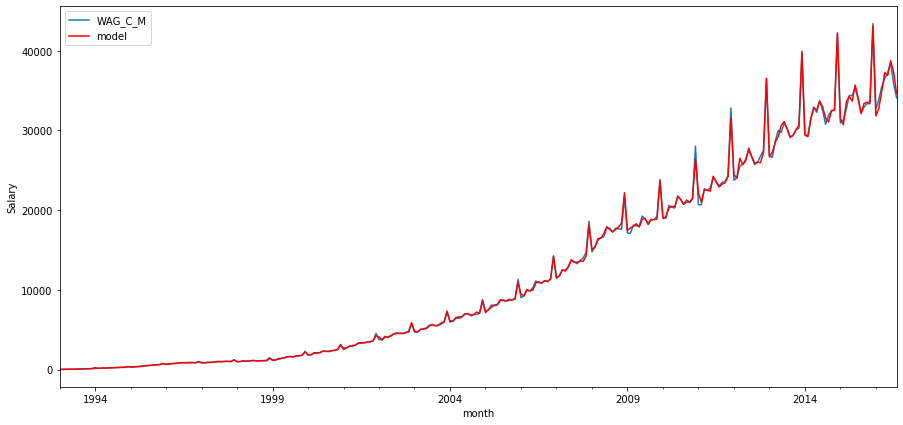

In [198]:
salary_data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary_data.WAG_C_M.plot()
salary_data.model.plot(color='r')
plt.ylabel('Salary')
pylab.legend()
pylab.show()

### Прогнозирование с помощью финальной модели

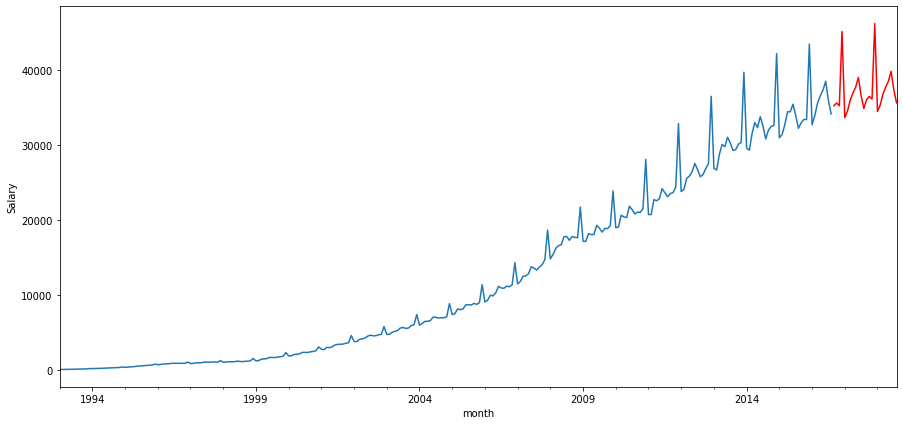

In [250]:
date_list = [datetime.datetime.strptime("2016-09-08", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
forecast = invboxcox(best_model.predict(start=284, end=307), lmbda)
future = pd.DataFrame(forecast.values, index=date_list, columns=['WAG_C_M'])

plt.figure(figsize(15,7))
salary_data.WAG_C_M.plot()
future.WAG_C_M.plot(color='r')
plt.ylabel('Salary')
pylab.show()